In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Prepare and normalize structural features"""
    # Extract SASA
    sasa = df['sasa'].values.reshape(-1, 1)
    
    # Convert string arrays to numerical arrays for angles
    phi_small = np.array([eval(x) for x in df['phi_small']])
    psi_small = np.array([eval(x) for x in df['psi_small']])
    
    # Convert secondary structure to one-hot encoding
    ss = np.column_stack((df['E'], df['H'], df['L']))
    
    # Normalize SASA and angles
    scaler_sasa = StandardScaler()
    sasa_normalized = scaler_sasa.fit_transform(sasa)
    
    scaler_phi = StandardScaler()
    phi_normalized = scaler_phi.fit_transform(phi_small)
    
    scaler_psi = StandardScaler()
    psi_normalized = scaler_psi.fit_transform(psi_small)
    
    # Combine all features
    features = np.concatenate([
        sasa_normalized,
        phi_normalized,
        psi_normalized,
        ss
    ], axis=1)
    
    return features

In [11]:
def prepare_structure_data(df):
   """Prepare and normalize structural features"""
   # Extract SASA
   sasa = df['sasa'].values.reshape(-1, 1)
   
   # Convert secondary structure to one-hot encoding
   ss = np.column_stack((df['E'], df['H'], df['L']))
   
   # Normalize SASA
   scaler_sasa = StandardScaler()
   sasa_normalized = scaler_sasa.fit_transform(sasa)
   
   return sasa_normalized, ss

In [12]:
def create_sequence_model():
   """Create CNN model for sequence data"""
   seq_input = tf.keras.layers.Input(shape=(33,))
   x = tf.keras.layers.Embedding(21, 21)(seq_input)
   x = tf.keras.layers.Reshape((33, 21, 1))(x)
   x = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
   x = tf.keras.layers.Flatten()(x)
   seq_features = tf.keras.layers.Dense(32, activation='relu')(x)
   
   return tf.keras.Model(inputs=seq_input, outputs=seq_features)

In [13]:
def create_structure_model():
   """Create model for structural features"""
   # SASA input
   sasa_input = tf.keras.layers.Input(shape=(1,))
   sasa_features = tf.keras.layers.Dense(8, activation='relu')(sasa_input)
   
   # Secondary structure input
   ss_input = tf.keras.layers.Input(shape=(3,))
   ss_features = tf.keras.layers.Dense(8, activation='relu')(ss_input)
   
   # Combine structural features
   combined = tf.keras.layers.Concatenate()([sasa_features, ss_features])
   struct_features = tf.keras.layers.Dense(32, activation='relu')(combined)
   
   return tf.keras.Model(
       inputs=[sasa_input, ss_input],
       outputs=struct_features
   )

In [14]:
def create_ensemble_model():
   """Create ensemble model combining sequence and structure"""
   # Sequence branch
   seq_input = tf.keras.layers.Input(shape=(33,))
   seq_model = create_sequence_model()
   seq_features = seq_model(seq_input)
   
   # Structure branch
   sasa_input = tf.keras.layers.Input(shape=(1,))
   ss_input = tf.keras.layers.Input(shape=(3,))
   
   struct_model = create_structure_model()
   struct_features = struct_model([sasa_input, ss_input])
   
   # Combine features
   combined = tf.keras.layers.Concatenate()([seq_features, struct_features])
   
   # Final dense layers
   x = tf.keras.layers.Dense(64, activation='relu')(combined)
   x = tf.keras.layers.Dropout(0.3)(x)
   x = tf.keras.layers.Dense(32, activation='relu')(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
   
   return tf.keras.Model(
       inputs=[seq_input, sasa_input, ss_input],
       outputs=output
   )

In [15]:
def train_and_evaluate():
   # Load data
   print("Loading data...")
   train_df = pd.read_csv("../new/processed_data_train.csv")
   test_df = pd.read_csv("../new/processed_data_test.csv")
   
   # Shuffle both training and test data
   print("Shuffling data...")
   train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
   test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
   
   # Print class distribution
   print("\nTraining set distribution:")
   print(train_df['label'].value_counts())
   print("\nTest set distribution:")
   print(test_df['label'].value_counts())
   
   # Prepare data
   print("\nPreparing data...")
   X_train_seq = prepare_sequence_data(train_df)
   X_test_seq = prepare_sequence_data(test_df)
   
   X_train_sasa, X_train_ss = prepare_structure_data(train_df)
   X_test_sasa, X_test_ss = prepare_structure_data(test_df)
   
   y_train = train_df['label'].values
   y_test = test_df['label'].values
   
   print(f"\nTraining sequence data shape: {X_train_seq.shape}")
   print(f"Training SASA data shape: {X_train_sasa.shape}")
   print(f"Training SS data shape: {X_train_ss.shape}")
   
   # Calculate class weights
   total_samples = len(y_train)
   pos_samples = np.sum(y_train == 1)
   neg_samples = np.sum(y_train == 0)
   
   class_weights = {
       0: total_samples / (2 * neg_samples),
       1: total_samples / (2 * pos_samples)
   }
   
   print("\nClass weights:", class_weights)
   
   # Initialize cross-validation
   kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
   
   # Initialize metrics storage
   metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
   test_predictions = []
   
   # Cross-validation loop
   for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
       print(f"\nFold {fold}/5")
       
       # Create callbacks
       early_stopping = tf.keras.callbacks.EarlyStopping(
           monitor='val_loss',
           patience=5,
           restore_best_weights=True
       )
       
       # Create and compile model
       model = create_ensemble_model()
       model.compile(
           optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
           loss='binary_crossentropy',
           metrics=['accuracy']
       )
       
       # Prepare fold data
       train_data = [
           X_train_seq[train_idx],
           X_train_sasa[train_idx],
           X_train_ss[train_idx]
       ]
       val_data = [
           X_train_seq[val_idx],
           X_train_sasa[val_idx],
           X_train_ss[val_idx]
       ]
       
       # Train model
       print("Training model...")
       history = model.fit(
           train_data, y_train[train_idx],
           batch_size=32,
           epochs=50,
           validation_data=(val_data, y_train[val_idx]),
           callbacks=[early_stopping],
           class_weight=class_weights,
           verbose=1
       )
       
       # Plot training history
       plt.figure(figsize=(10, 6))
       plt.plot(history.history['accuracy'], label='Train Accuracy')
       plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
       plt.title(f'Model Accuracy - Fold {fold}')
       plt.xlabel('Epoch')
       plt.ylabel('Accuracy')
       plt.legend()
       plt.show()
       
       # Evaluate on validation set
       y_pred = model.predict(val_data)
       y_pred_binary = (y_pred > 0.5).astype(int)
       
       # Calculate metrics
       cm = confusion_matrix(y_train[val_idx], y_pred_binary)
       metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
       metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
       metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
       metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
       metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
       
       # Predict on test set
       test_pred = model.predict([X_test_seq, X_test_sasa, X_test_ss])
       test_predictions.append(test_pred)
       
       print(f"\nFold {fold} Results:")
       print(f"Accuracy: {metrics['acc'][-1]:.4f}")
       print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
       print(f"MCC: {metrics['mcc'][-1]:.4f}")
       print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
       print(f"Specificity: {metrics['sp'][-1]:.4f}")
   
   # Print average cross-validation results
   print("\nAverage Cross-validation Results:")
   for metric in metrics:
       print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
   
   # Ensemble predictions on test set
   test_pred_avg = np.mean(test_predictions, axis=0)
   test_pred_binary = (test_pred_avg > 0.5).astype(int)
   
   # Calculate final test metrics
   cm_test = confusion_matrix(y_test, test_pred_binary)
   test_balanced_acc = balanced_accuracy_score(y_test, test_pred_binary)
   
   print("\nFinal Test Set Results:")
   print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
   print(f"Balanced Accuracy: {test_balanced_acc:.4f}")
   print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
   print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
   print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
   print("Confusion Matrix:")
   print(cm_test)
   
   return model

Loading data...
Shuffling data...

Training set distribution:
label
1    4591
0    4259
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Preparing data...

Training sequence data shape: (8850, 33)
Training SASA data shape: (8850, 1)
Training SS data shape: (8850, 3)

Class weights: {0: 1.0389762855130311, 1: 0.9638423001524722}

Fold 1/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4942 - loss: 0.6934 - val_accuracy: 0.5328 - val_loss: 0.6898
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5596 - loss: 0.6811 - val_accuracy: 0.6475 - val_loss: 0.6360
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6679 - loss: 0.6177 - val_accuracy: 0.6780 - val_loss: 0.5984
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7206 - loss: 0.5580 - val_accuracy: 0.7243 - val_loss: 0.5542
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7589 

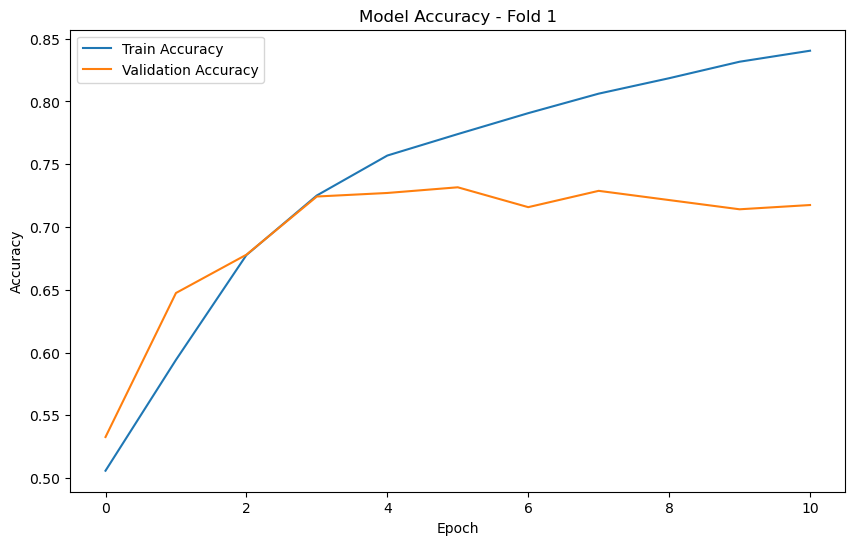

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7316
Balanced Accuracy: 0.7265
MCC: 0.4567
Sensitivity: 0.7842
Specificity: 0.6687

Fold 2/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5023 - loss: 0.6917 - val_accuracy: 0.6062 - val_loss: 0.6544
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6474 - loss: 0.6367 - val_accuracy: 0.6977 - val_loss: 0.5863
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7293 - loss: 0.5587 - val_accuracy: 0.7164 - val_loss: 0.5496
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7536 - loss: 0.5160 - val_accuracy: 0.7322 - val_loss: 0.5273
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7763 - loss: 0.4898 - val_accuracy: 0.7215 - val_loss: 0.5385
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7871 - loss: 0.4689 - val_accuracy: 0.7277 - val_loss: 0.5384
Epoch 7/

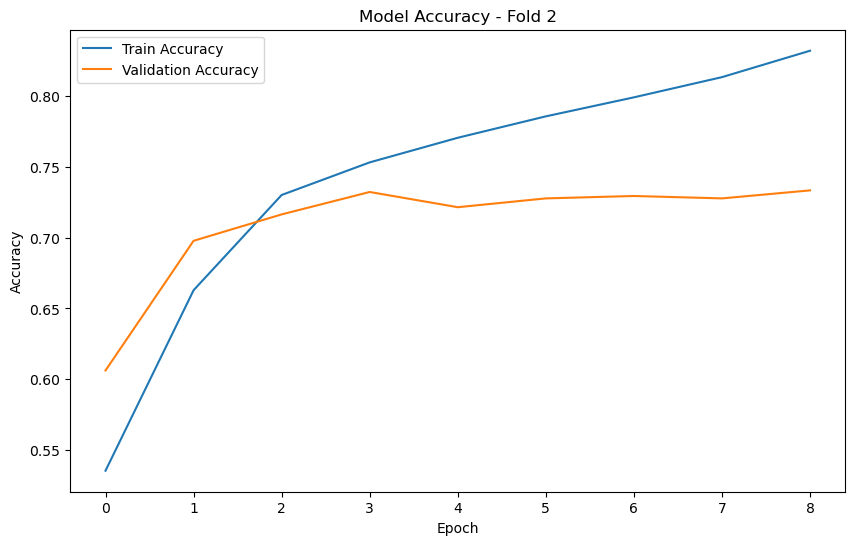

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7234
MCC: 0.4692
Sensitivity: 0.8649
Specificity: 0.5819

Fold 3/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4994 - loss: 0.6926 - val_accuracy: 0.6090 - val_loss: 0.6565
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6338 - loss: 0.6453 - val_accuracy: 0.6514 - val_loss: 0.6197
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6862 - loss: 0.6007 - val_accuracy: 0.6955 - val_loss: 0.5748
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7221 - loss: 0.5569 - val_accuracy: 0.7294 - val_loss: 0.5441
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7625 - loss: 0.5089 - val_accuracy: 0.7305 - val_loss: 0.5371
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7794 - loss: 0.4907 - val_accuracy: 0.7294 - val_loss: 0.5400
Epoch 7

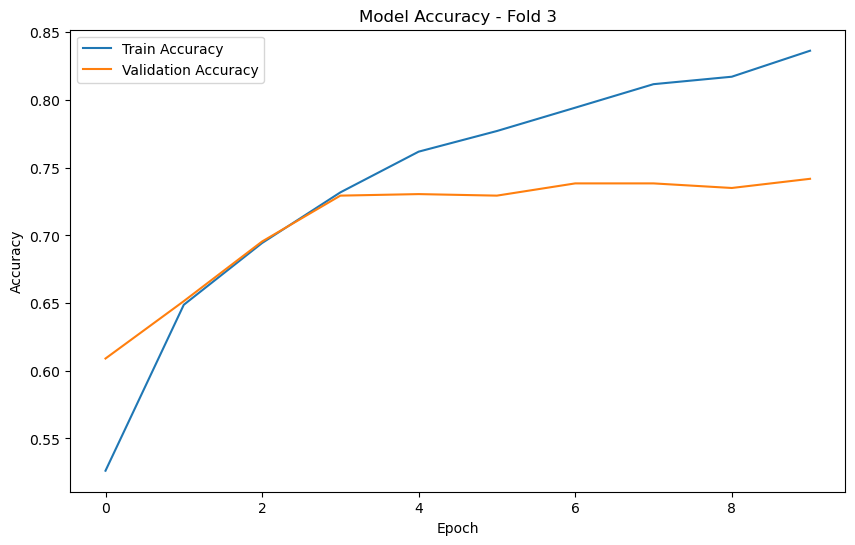

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 3 Results:
Accuracy: 0.7305
Balanced Accuracy: 0.7294
MCC: 0.4749
Sensitivity: 0.8567
Specificity: 0.6021

Fold 4/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5099 - loss: 0.6917 - val_accuracy: 0.5960 - val_loss: 0.6613
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6385 - loss: 0.6451 - val_accuracy: 0.6627 - val_loss: 0.6130
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6858 - loss: 0.6012 - val_accuracy: 0.7056 - val_loss: 0.5773
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7231 - loss: 0.5531 - val_accuracy: 0.7271 - val_loss: 0.5447
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7468 - loss: 0.5204 - val_accuracy: 0.7350 - val_loss: 0.5315
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7690 - loss: 0.4869 - val_accuracy: 0.7203 - val_loss: 0.5491
Epoch 7

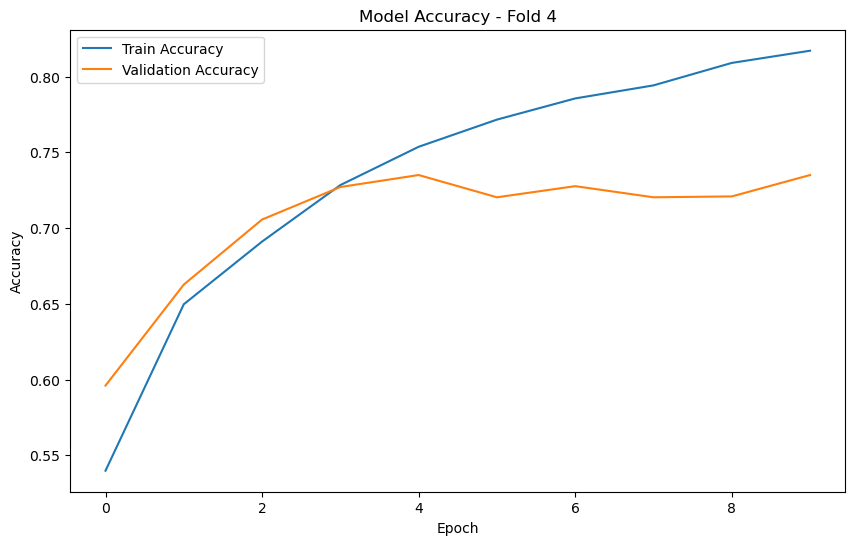

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7350
Balanced Accuracy: 0.7354
MCC: 0.4734
Sensitivity: 0.7895
Specificity: 0.6813

Fold 5/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5096 - loss: 0.6942 - val_accuracy: 0.5322 - val_loss: 0.6894
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5444 - loss: 0.6865 - val_accuracy: 0.7000 - val_loss: 0.5902
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7021 - loss: 0.5773 - val_accuracy: 0.7299 - val_loss: 0.5371
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7418 - loss: 0.5302 - val_accuracy: 0.7345 - val_loss: 0.5419
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7628 - loss: 0.5000 - val_accuracy: 0.7412 - val_loss: 0.5355
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7752 - loss: 0.4788 - val_accuracy: 0.7299 - val_loss: 0.5440
Epoch 7/

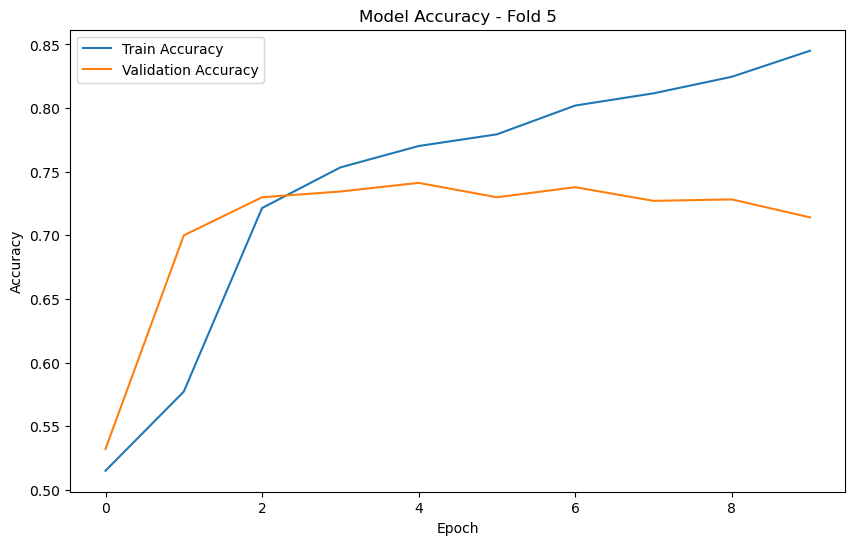

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7412
Balanced Accuracy: 0.7418
MCC: 0.4834
Sensitivity: 0.7257
Specificity: 0.7579

Average Cross-validation Results:
ACC: 0.7341 ± 0.0039
BALANCED_ACC: 0.7313 ± 0.0066
MCC: 0.4715 ± 0.0087
SN: 0.8042 ± 0.0514
SP: 0.6584 ± 0.0625

Final Test Set Results:
Accuracy: 0.6847
Balanced Accuracy: 0.7274
MCC: 0.2673
Sensitivity: 0.7792
Specificity: 0.6756
Confusion Matrix:
[[1687  810]
 [  53  187]]


In [16]:
if __name__ == "__main__":
    model = train_and_evaluate()